# U-Net model with HOG features images

---



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import shutil
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from skimage import exposure
from skimage import io, feature
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras.layers import Input, Concatenate
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Input, Model

from skimage import color
from skimage.transform import resize
import math
from skimage.feature import hog
from skimage.io import imread, imshow

In [24]:
def read_data(data_dir, height, width):
    # Initialize lists for images, mask, labels, and HOG features
    images = []
    masks = []
    labels = []
    hog_images = []
    classes = {'normal': 0, 'benign': 1, 'malignant' : 2}

    for class_name, class_label in classes.items():
        class_dir = os.path.join(data_dir, class_name)
        for image_file in os.listdir(class_dir):
            if image_file.endswith(".png") and 'mask' not in image_file:
                # Load the original image
                image_path = os.path.join(class_dir, image_file)
                images.append(image_path)


                # Extract HOG features
                image = io.imread(image_path)
                fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=True)
                #hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
                #hog_image_rgb = np.repeat(hog_image_rescaled[:, :, np.newaxis], 3, axis=2)

                # Reshape the HOG image to match the target dimensions
                #hog_image_resized = cv2.resize(hog_image_rgb, (width, height))

                hog_images.append(hog_image)

                # Find all masks associated with the image
                image_name = os.path.splitext(image_file)[0]  # Remove the file extension
                matching_masks = [f for f in os.listdir(class_dir) if f == image_name + '_mask.png']
                for mask_file in matching_masks:
                    mask_path = os.path.join(class_dir, mask_file)
                    masks.append(mask_path)

                class_label = classes[class_name]
                labels.append(class_name)

    return images, masks, labels, hog_images

# Call the function with the appropriate target height and width
height = 128  # Specify the target height
width = 128  # Specify the target width
channels = 3
data_dir = '/content/drive/MyDrive/US dataset/balanced_data'
images, masks, labels, hog_images = read_data(data_dir, height, width)

<ipython-input-24-9c17301c8197>:20: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=True)


In [27]:
hog_images[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

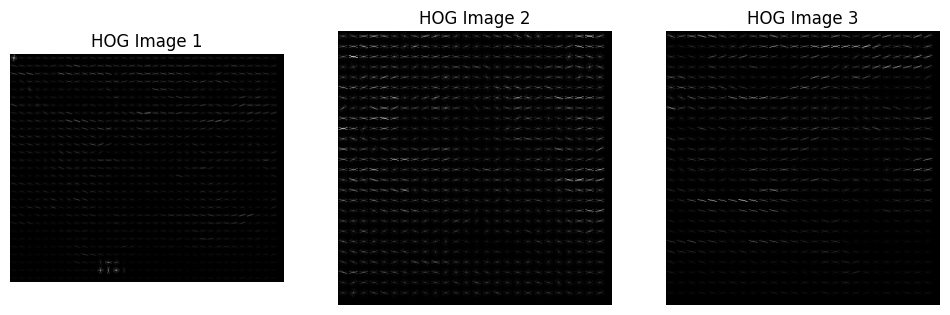

In [33]:
import random

# Choose three random indices
random_indices = random.sample(range(len(hog_images)), 3)

# Plot the three random hog images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, idx in enumerate(random_indices):
    axes[i].imshow(hog_images[idx], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'HOG Image {i+1}')

plt.show()

In [34]:
print(len(images))
print(len(masks))
print(len(labels))
print(len(hog_images))

894
894
894
894


In [35]:
# Creating dataframe from the generated lists
df = pd.DataFrame({'hog_images': hog_images, 'masks': masks, 'labels': labels})

train_data, test_data = train_test_split(df, test_size = 0.2, random_state=42, stratify=df['labels'])
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
#val_data, test_data = train_test_split(test_data, test_size = 0.5, random_state=42, stratify=df['labels'])

In [36]:
# Initialize empty arrays for X_train and y_train
X_train = np.zeros((len(train_data), height, width, channels), dtype=np.uint8)
y_train = np.zeros((len(train_data), height, width, 1), dtype=bool)

# Iterate through the DataFrame to populate X_train and y_train
for idx, row in train_data.iterrows():
    hog_image = row['hog_images']
    mask_path = row['masks']

    # Load and resize the image
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    hog_image_rgb = np.repeat(hog_image_rescaled[:, :, np.newaxis], 3, axis=2)

    # Reshape the HOG image to match the target dimensions
    hog_image = cv2.resize(hog_image_rgb, (width, height))

    # Load and resize the mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (width, height))
    mask = np.expand_dims(mask, axis=-1)  # Expand dimensions to make it (height, width, 1)

    X_train[idx] = hog_image
    y_train[idx] = mask

In [37]:
# Initialize empty arrays for X_train and y_train
X_test = np.zeros((len(test_data), height, width, channels), dtype=np.uint8)
y_test = np.zeros((len(test_data), height, width, 1), dtype=bool)

# Iterate through the DataFrame to populate X_train and y_train
for idx, row in test_data.iterrows():
    hog_image = row['hog_images']
    mask_path = row['masks']

    # Load and resize the image
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    hog_image_rgb = np.repeat(hog_image_rescaled[:, :, np.newaxis], 3, axis=2)

    # Reshape the HOG image to match the target dimensions
    hog_image = cv2.resize(hog_image_rgb, (width, height))

    # Load and resize the mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (width, height))
    mask = np.expand_dims(mask, axis=-1)  # Expand dimensions to make it (height, width, 1)

    X_test[idx] = hog_image
    y_test[idx] = mask

In [38]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(715, 128, 128, 3)
(715, 128, 128, 1)
(179, 128, 128, 3)
(179, 128, 128, 1)


In [39]:
# Define the number of samples you want to plot
num_samples_to_plot = 5

# Create subplots for the images and their corresponding masks
fig, axes = plt.subplots(num_samples_to_plot, 2, figsize=(10, 10))

for i in range(num_samples_to_plot):
    # Randomly select an index from X_train and y_train
    idx = np.random.randint(0, len(X_train))

    # Get the image and mask
    hog_image = X_train[idx]
    mask = y_train[idx]

    # Plot the image
    axes[i, 0].imshow(hog_image)
    axes[i, 0].set_title("Image")

    # Plot the mask
    axes[i, 1].imshow(mask[:, :, 0], cmap='gray')
    axes[i, 1].set_title("Mask")

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

##Seeding

In [40]:
os.environ['PYTHONHASHSEED'] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

##Hyperparameters

In [41]:
batch_size = 8
learning_rate = 0.0001
epochs = 100
height = 128
width = 128
channels = 3

##U-Net

In [42]:
# Defining input layer and convert it to a floating naumber
inputs = tf.keras.layers.Input((width, height, channels))

s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

# Contracting Path/Encoder
# Dropout Layers to avoid overfitting
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(c5)

# Expansive Path/Decoder
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding = 'same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides = (2,2), padding = 'same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding = 'same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis =3)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

In [43]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                              

In [44]:
# Callbacks

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('unet_for_segmentation_hog.h5', verbose = 1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs') # need to modify
]

In [45]:
K.clear_session()

In [46]:
results = model.fit(X_train, y_train, validation_split=0.1, batch_size=batch_size, epochs = epochs, callbacks=callbacks)

Epoch 1/100
81/81 [==============================] - ETA: 0s - loss: 0.3220 - accuracy: 0.9161
Epoch 1: val_loss improved from inf to 0.25810, saving model to unet_for_segmentation_hog.h5
81/81 [==============================] - 115s 1s/step - loss: 0.3220 - accuracy: 0.9161 - val_loss: 0.2581 - val_accuracy: 0.9397
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/81 [==============================] - ETA: 0s - loss: 0.2561 - accuracy: 0.9181
Epoch 2: val_loss improved from 0.25810 to 0.18677, saving model to unet_for_segmentation_hog.h5
81/81 [==============================] - 111s 1s/step - loss: 0.2561 - accuracy: 0.9181 - val_loss: 0.1868 - val_accuracy: 0.9397
Epoch 3/100
81/81 [==============================] - ETA: 0s - loss: 0.2517 - accuracy: 0.9181
Epoch 3: val_loss did not improve from 0.18677
81/81 [==============================] - 110s 1s/step - loss: 0.2517 - accuracy: 0.9181 - val_loss: 0.2001 - val_accuracy: 0.9397
Epoch 4/100
81/81 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.9181
Epoch 4: val_loss did not improve from 0.18677
81/81 [==============================] - 112s 1s/step - loss: 0.2543 - accuracy: 0.9181 - val_loss: 0.2043 - val_accuracy: 0.9397
Epoch 5/100
81/81 [==============================] - ETA: 0s - loss: 0.2423 - accuracy: 0.9181
Epoch 5: val_loss did not improve from 0.18677
81/8

In [47]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose =1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose =1)
preds_test = model.predict(X_test, verbose =1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

6/6 [==============================] - 9s 1s/step


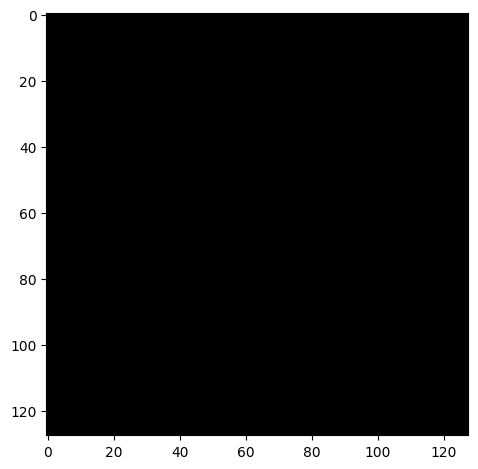

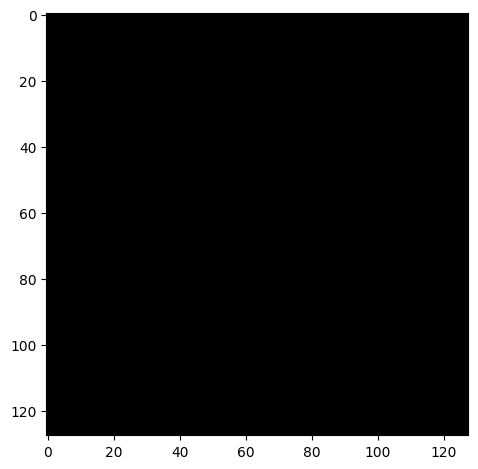

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


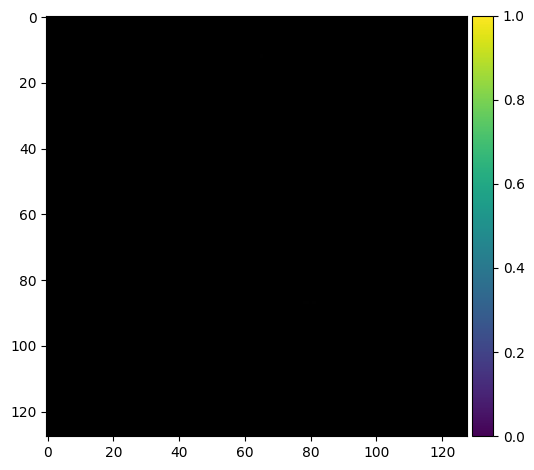

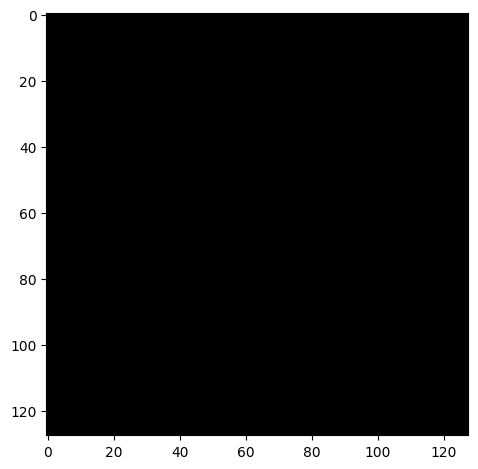

In [50]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9): ][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9): ][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()


In [51]:
# Plot training & validation accuracy values
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])

# Plot training & validation loss values
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])

plt.title('U-Net accuracy and loss on train and validation sets')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='center')
plt.show()

6/6 [==============================] - 6s 1s/step


<ipython-input-52-f5c649099bcc>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 3)


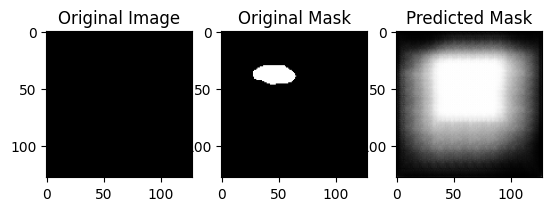

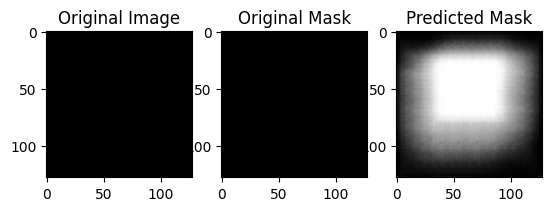

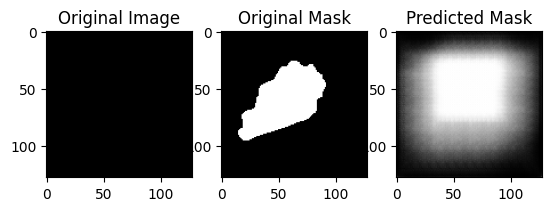

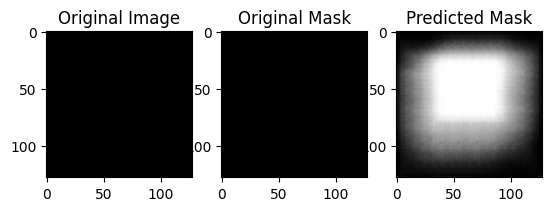

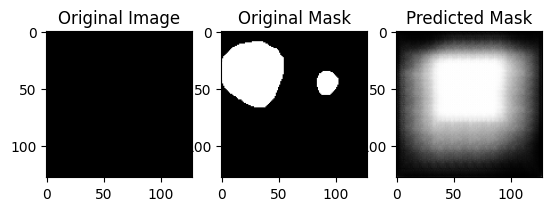

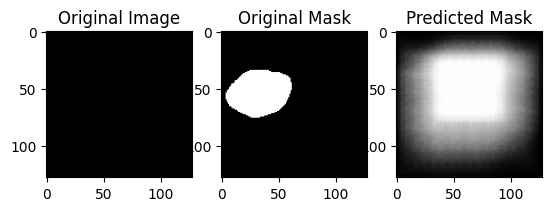

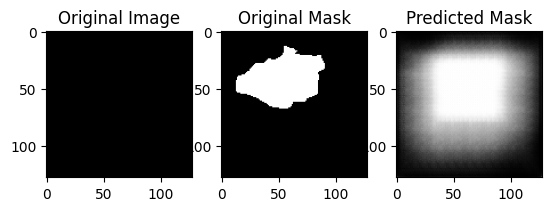

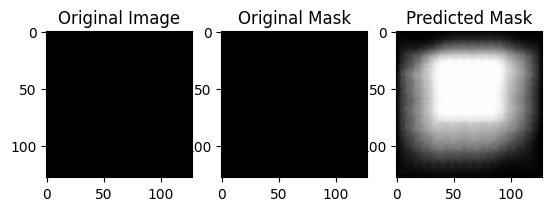

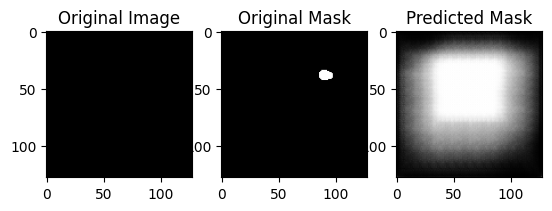

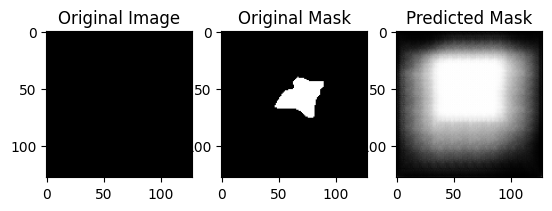

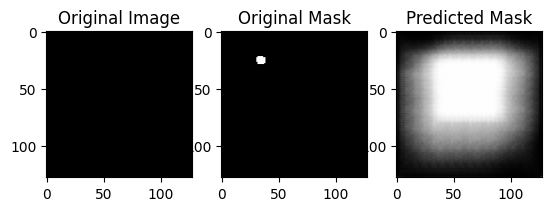

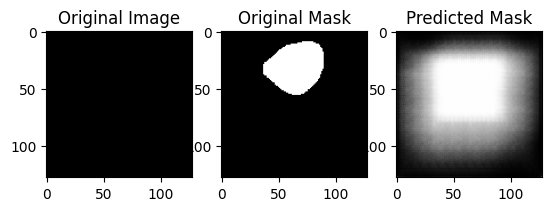

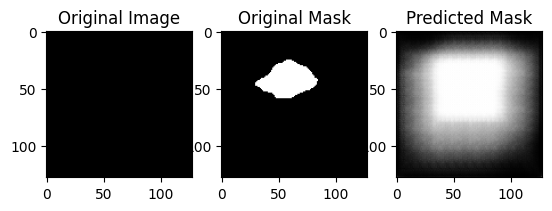

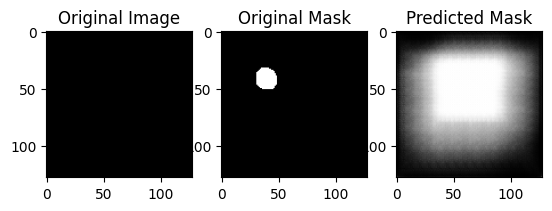

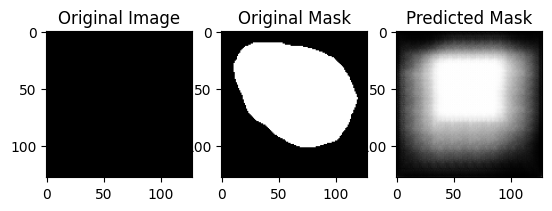

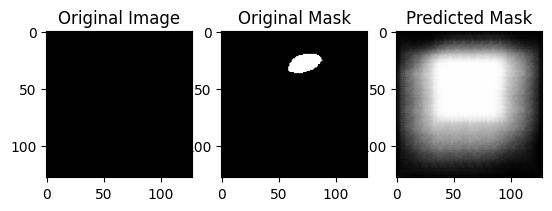

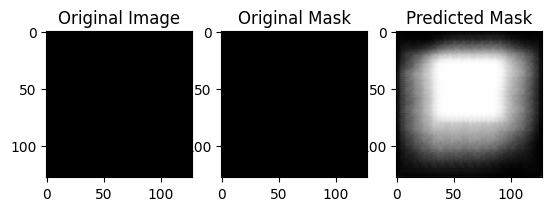

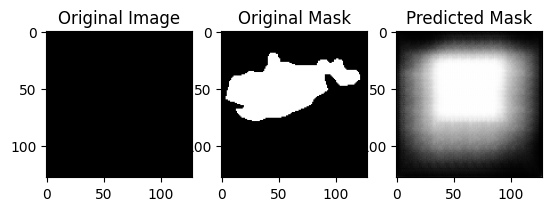

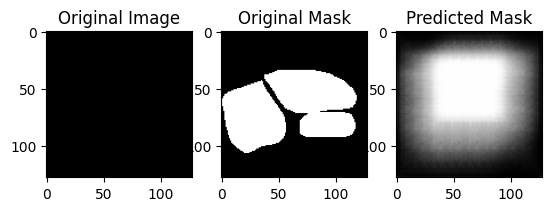

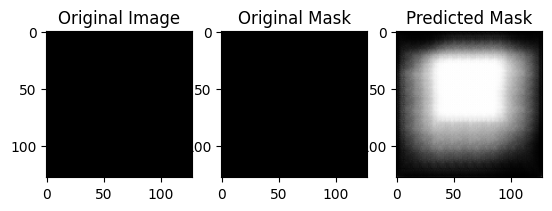

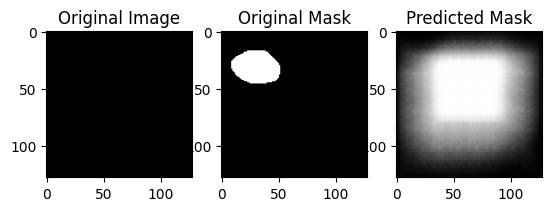

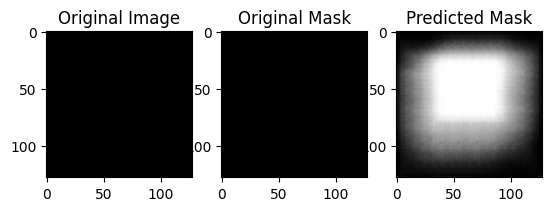

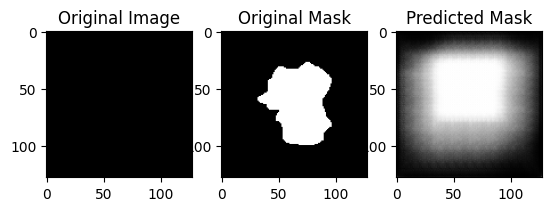

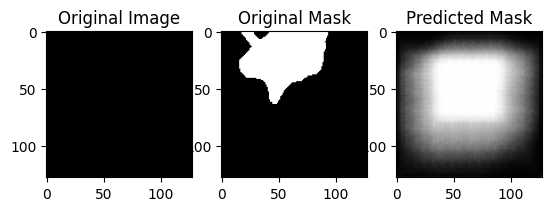

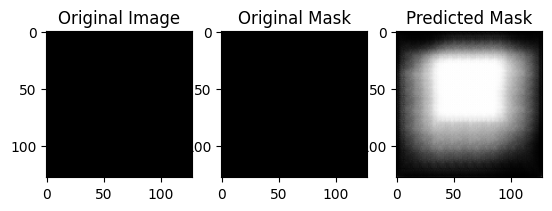

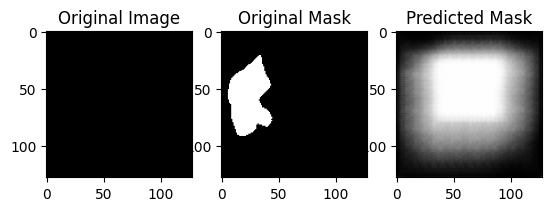

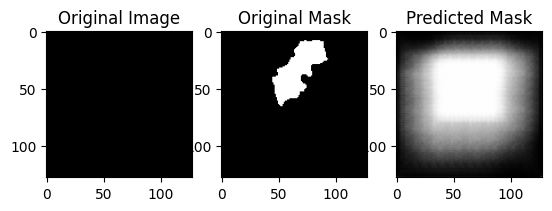

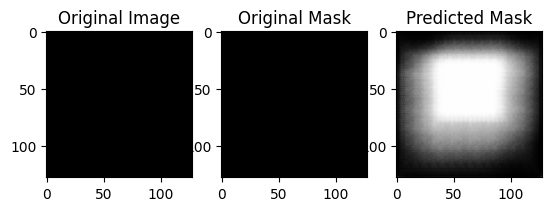

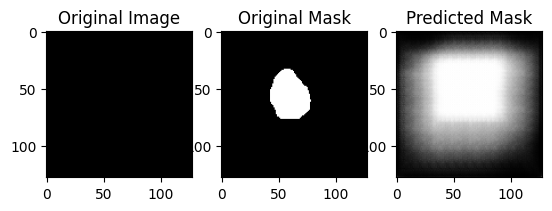

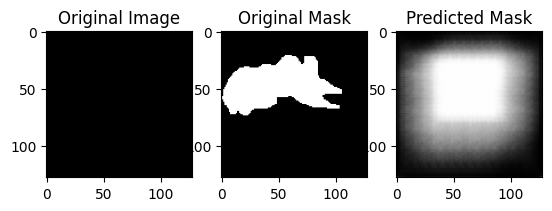

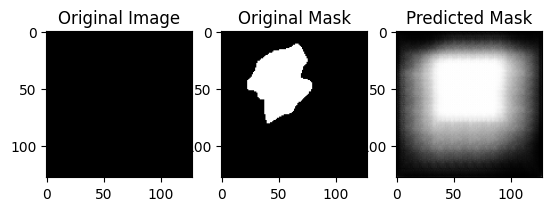

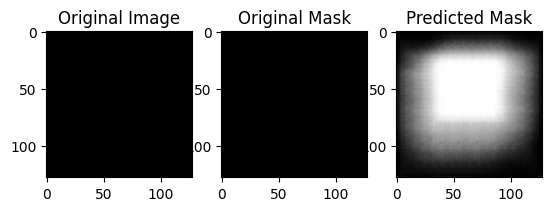

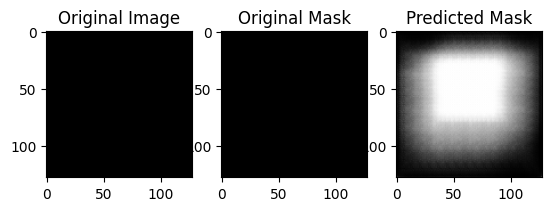

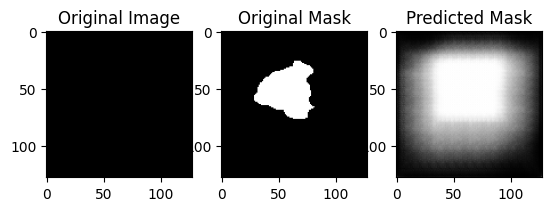

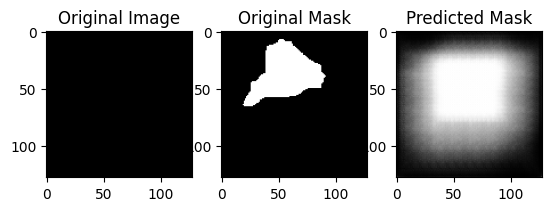

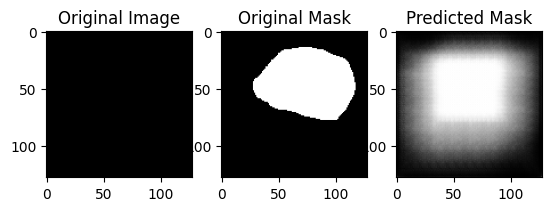

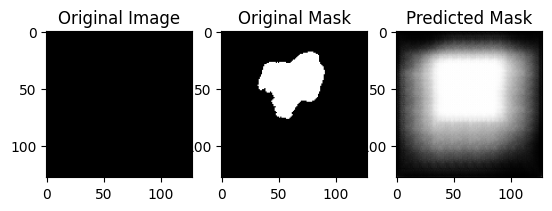

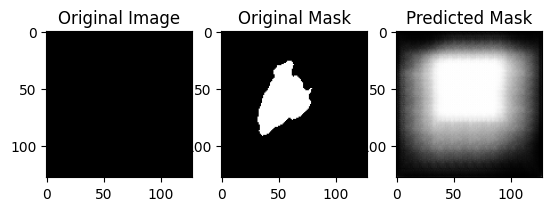

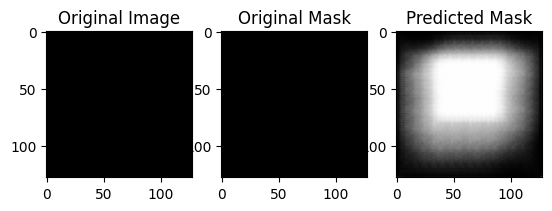

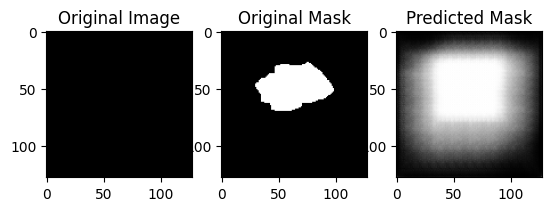

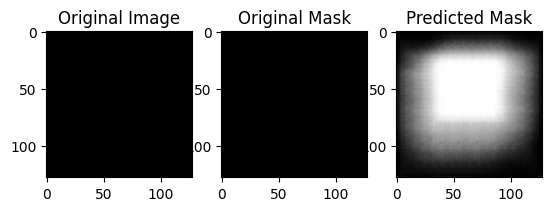

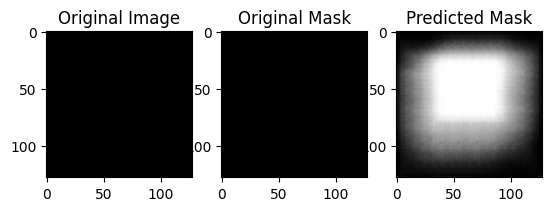

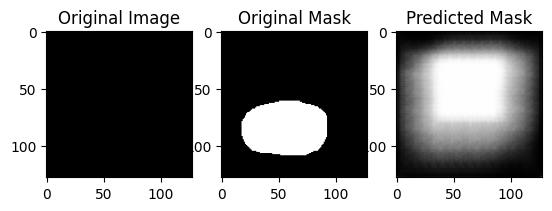

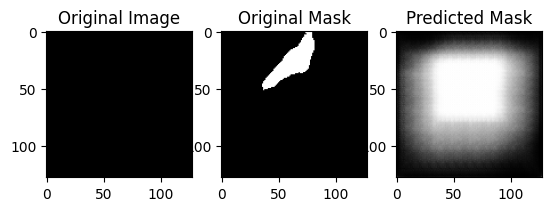

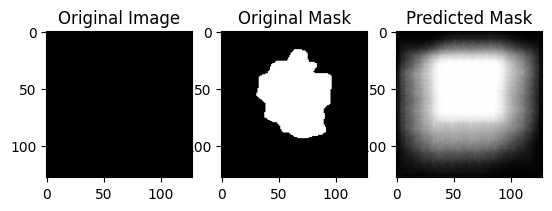

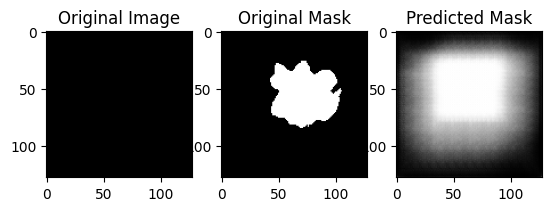

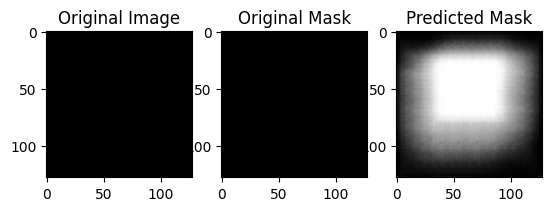

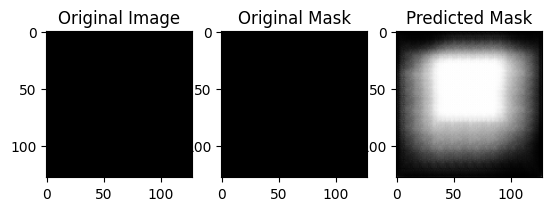

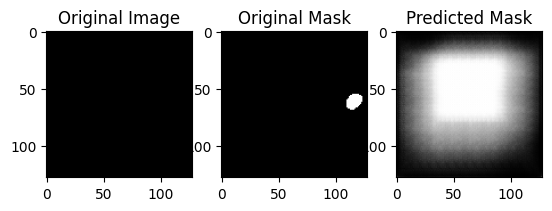

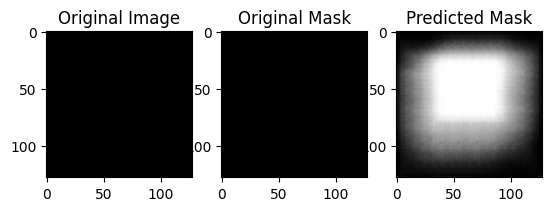

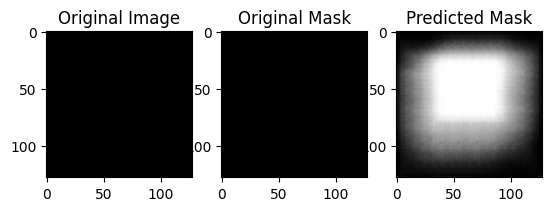

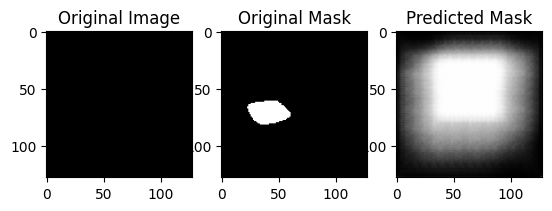

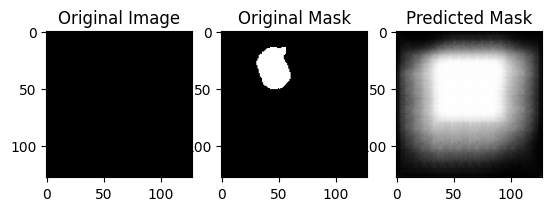

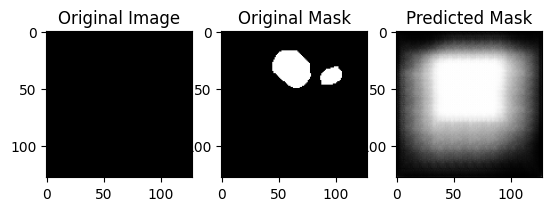

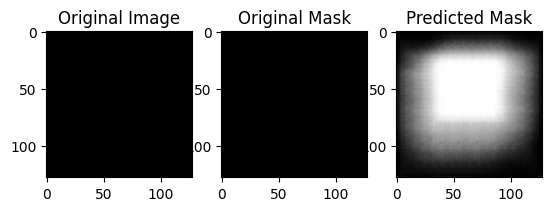

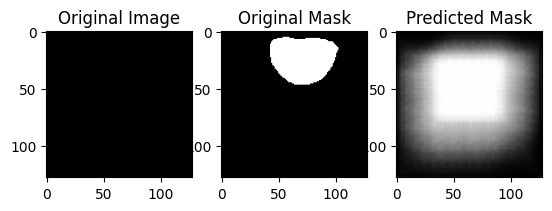

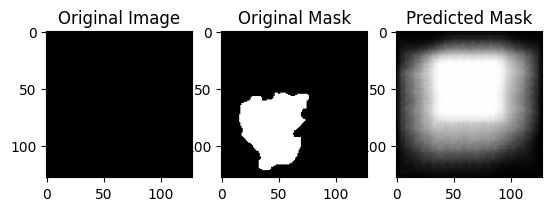

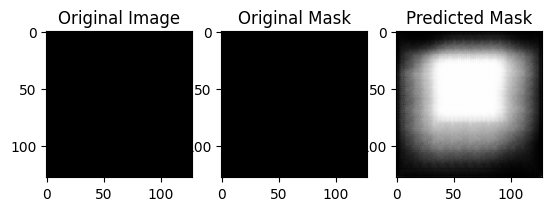

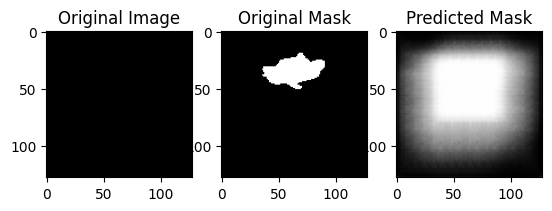

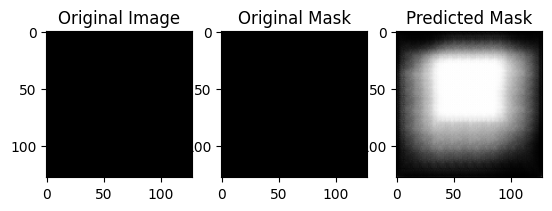

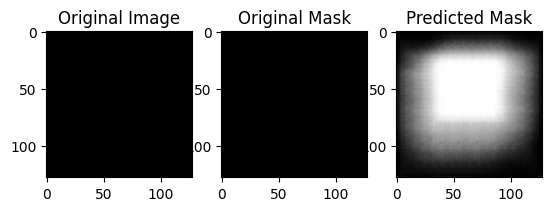

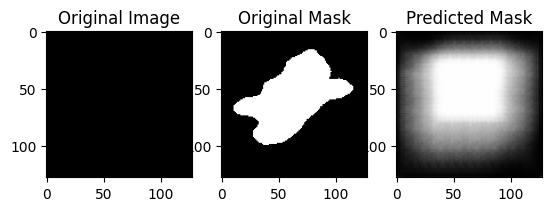

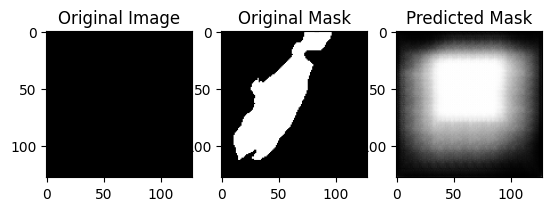

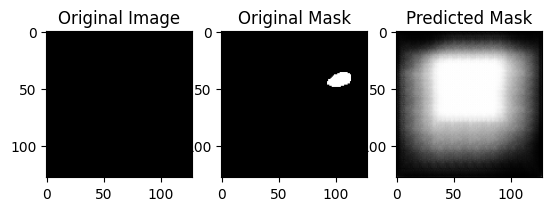

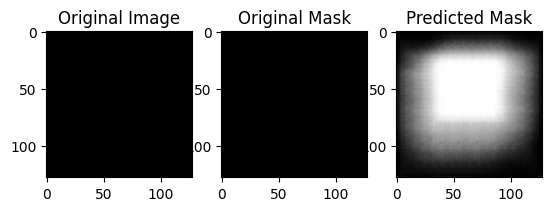

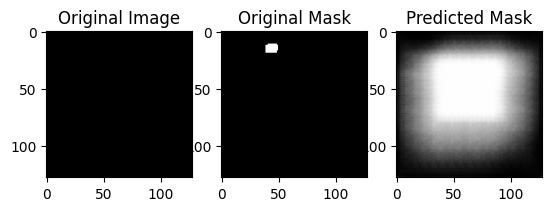

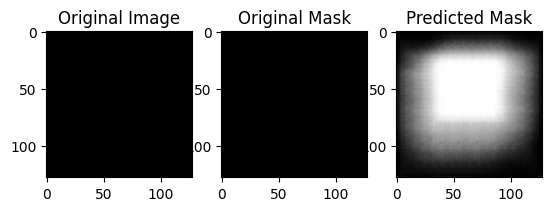

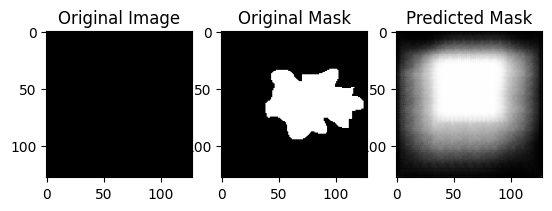

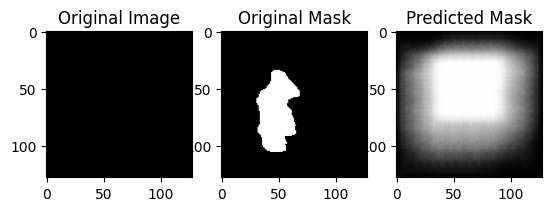

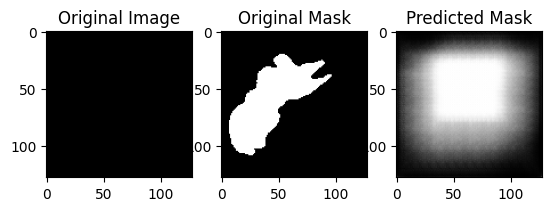

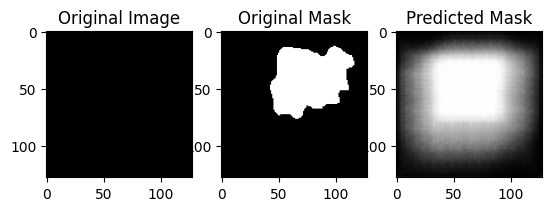

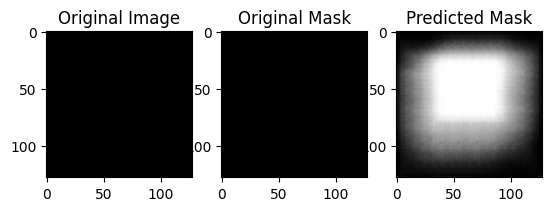

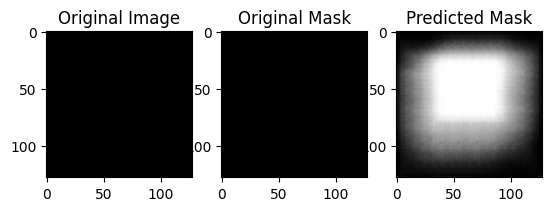

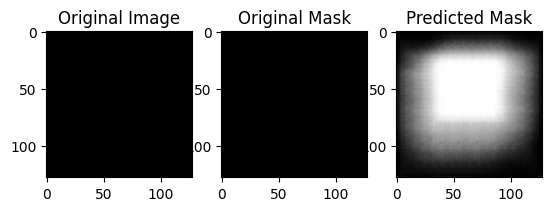

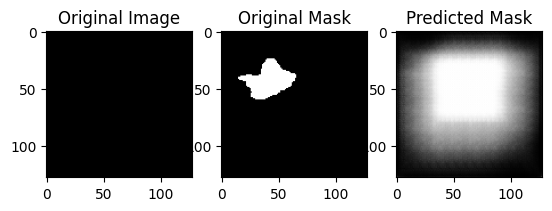

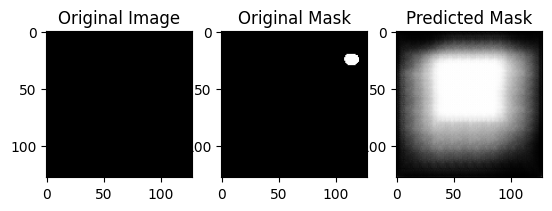

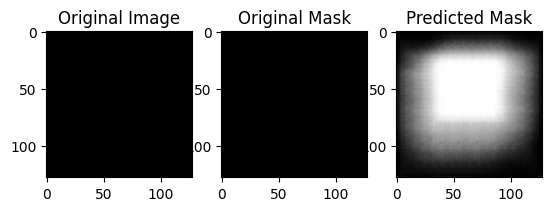

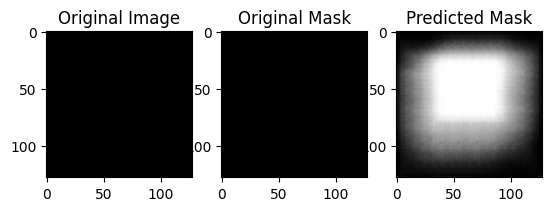

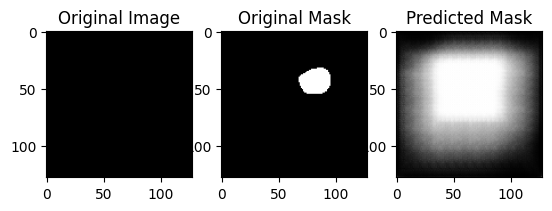

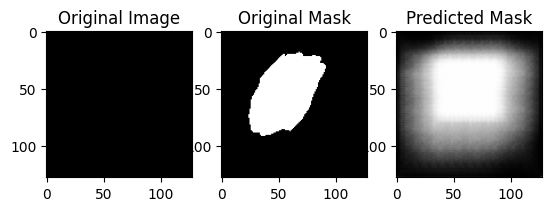

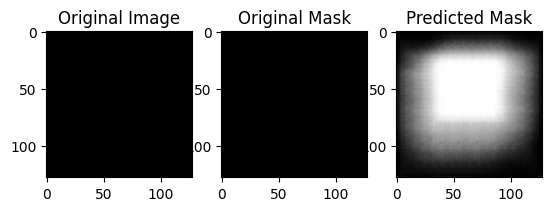

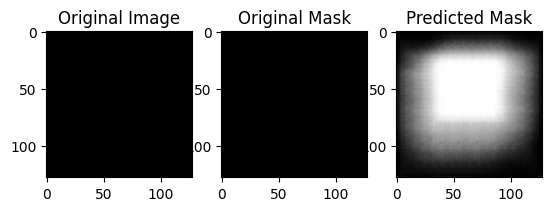

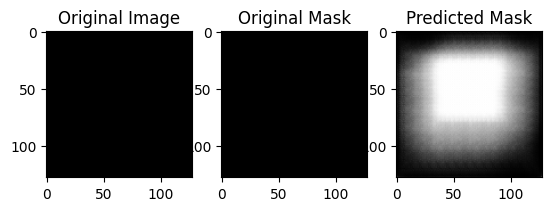

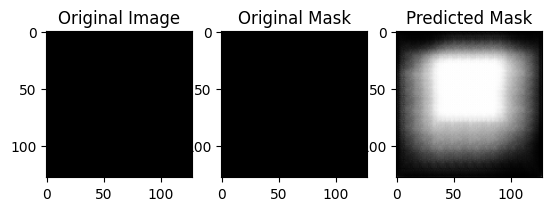

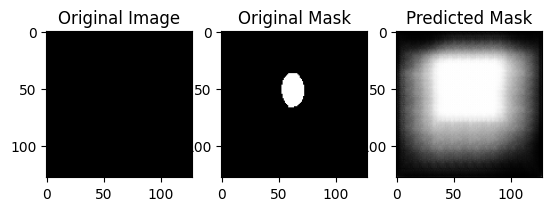

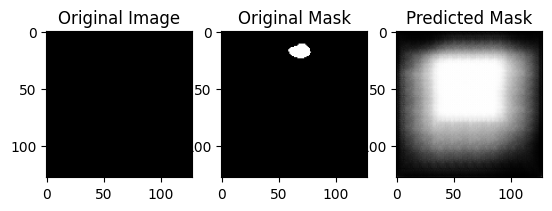

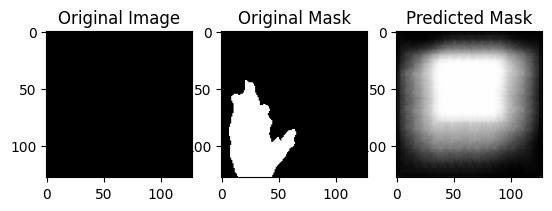

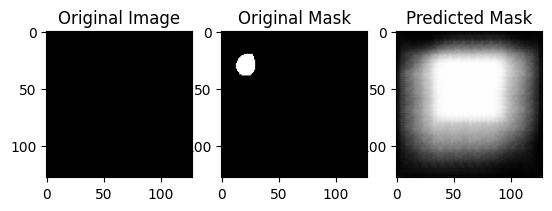

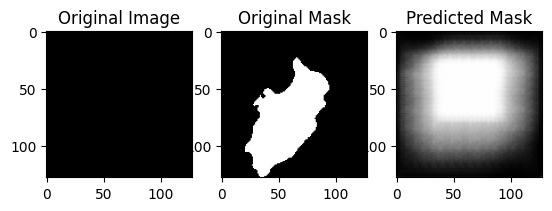

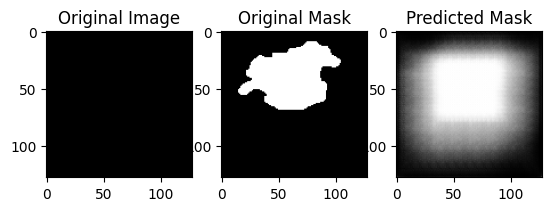

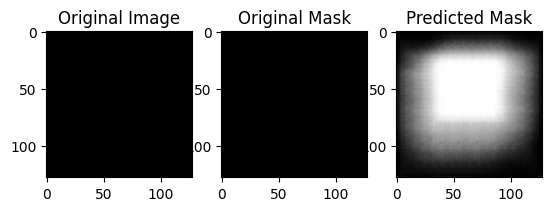

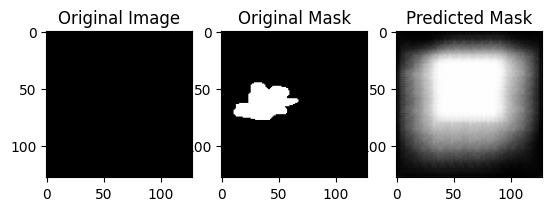

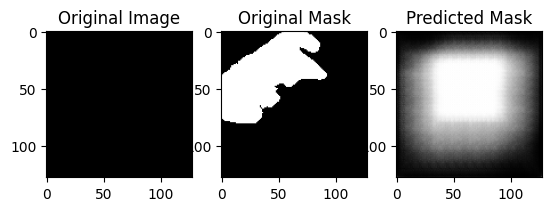

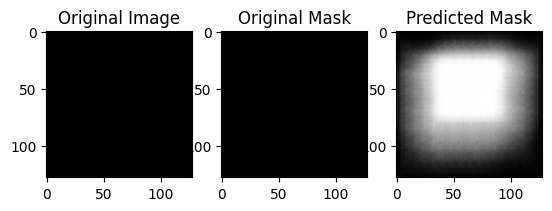

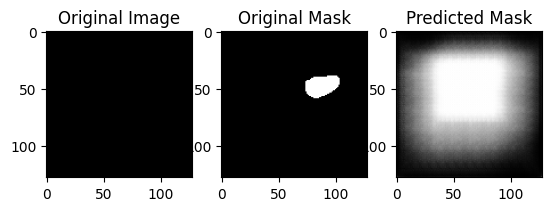

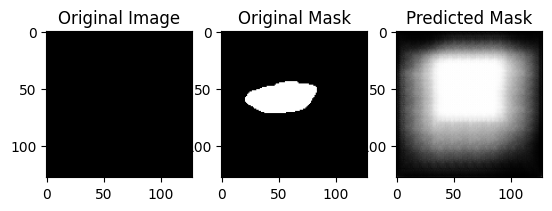

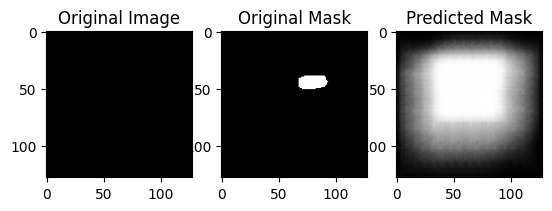

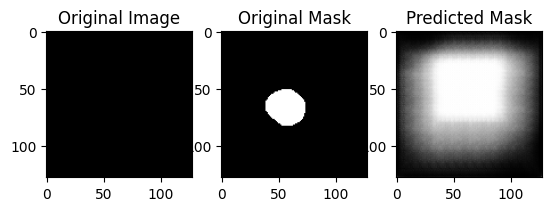

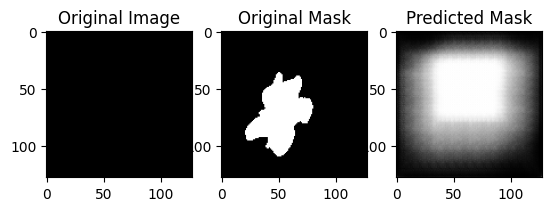

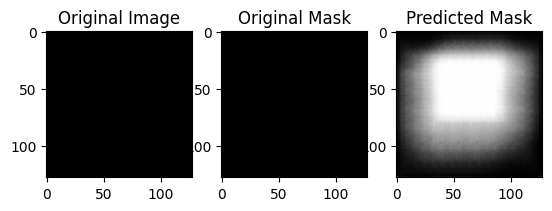

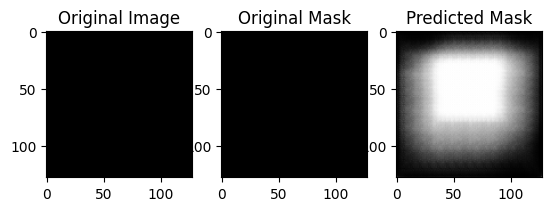

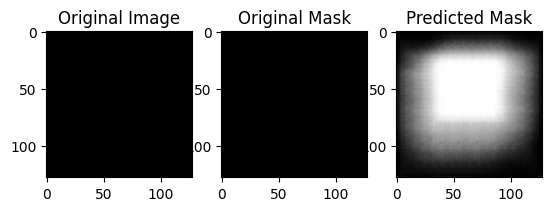

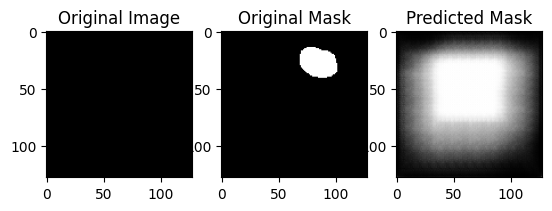

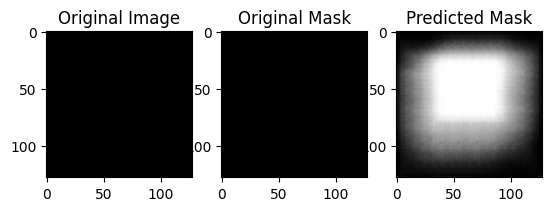

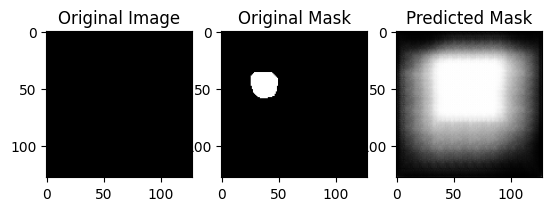

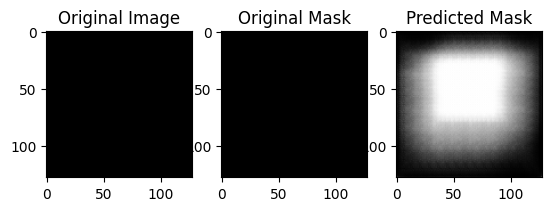

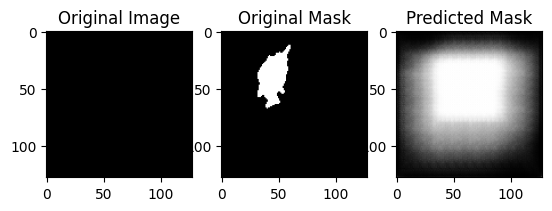

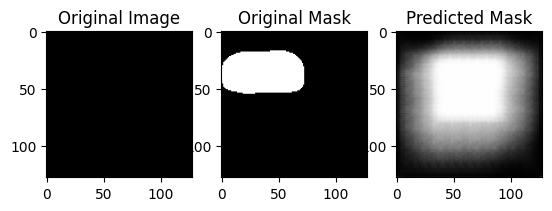

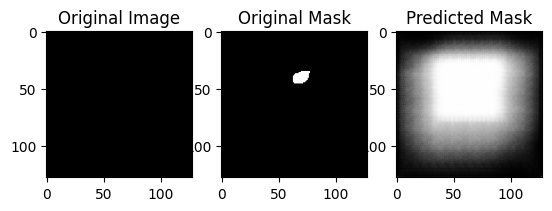

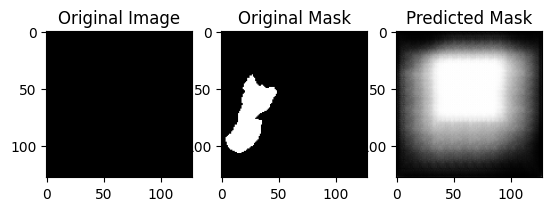

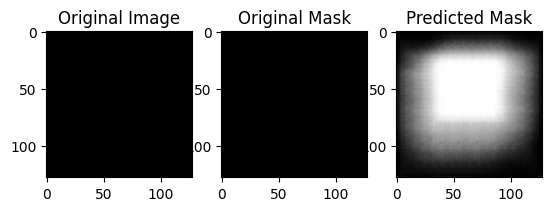

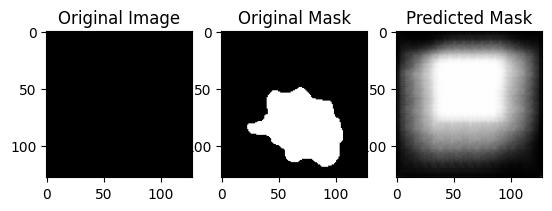

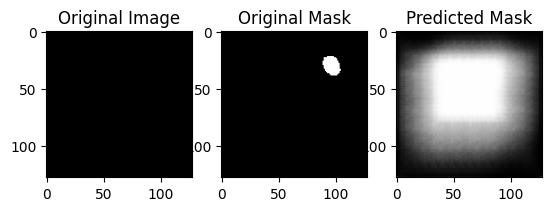

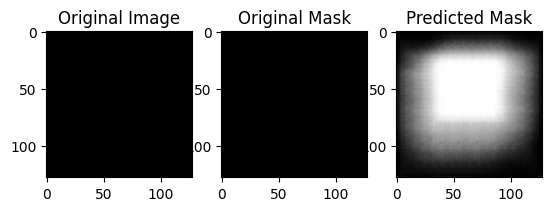

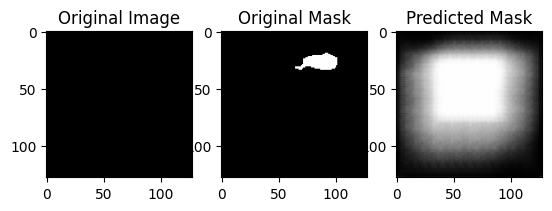

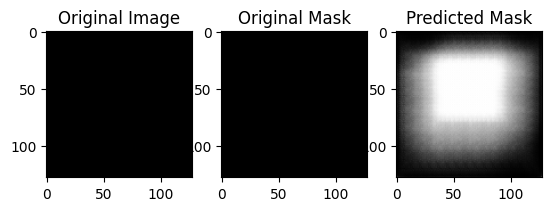

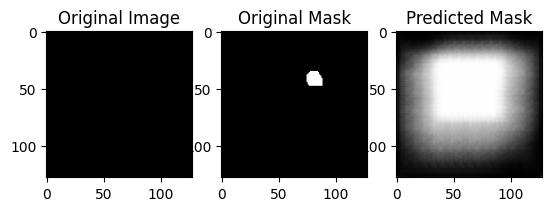

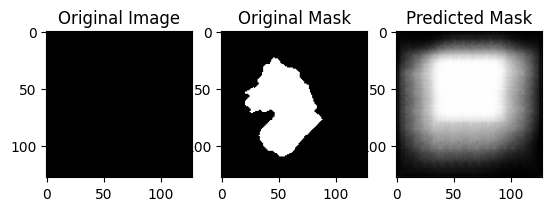

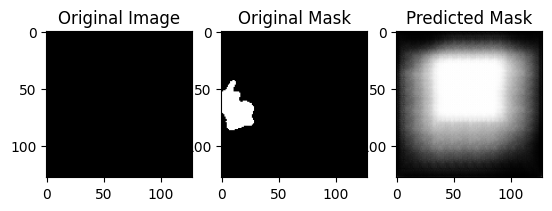

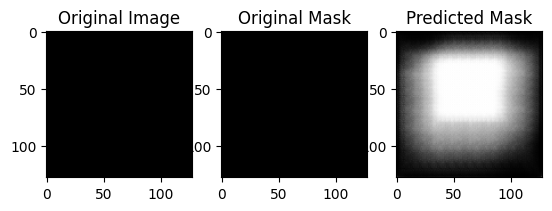

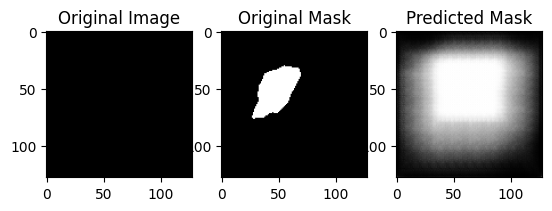

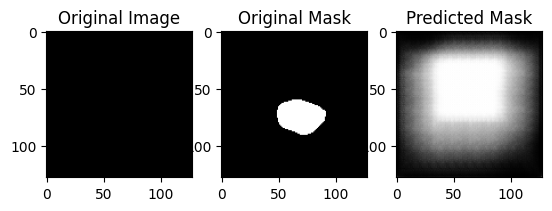

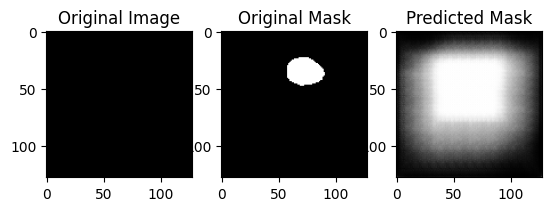

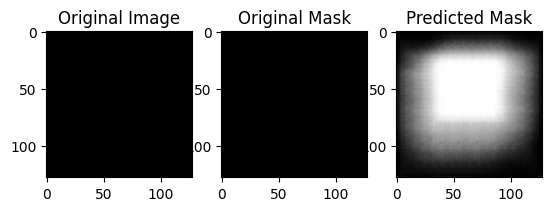

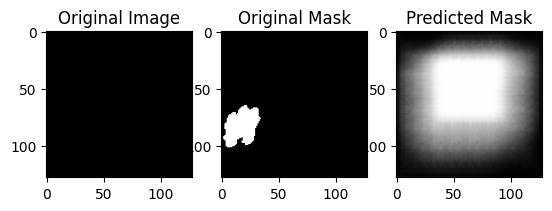

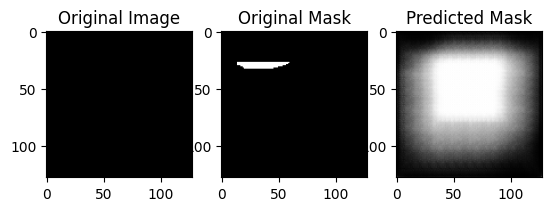

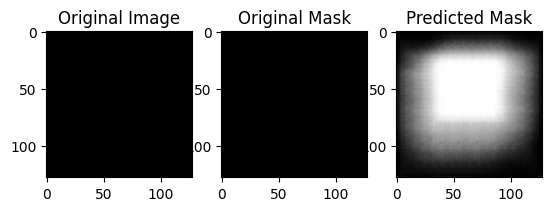

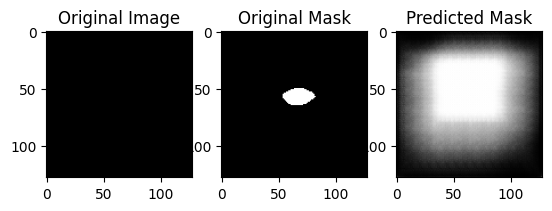

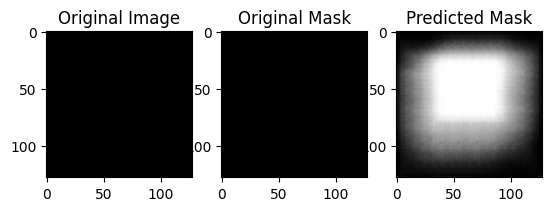

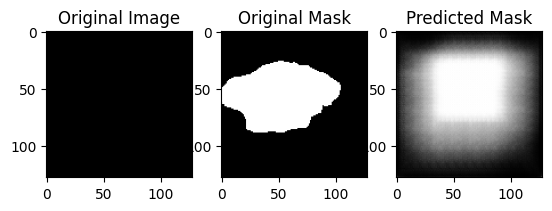

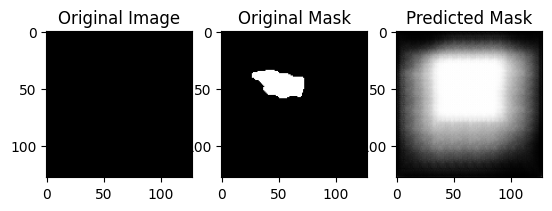

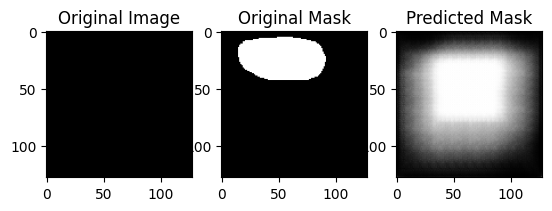

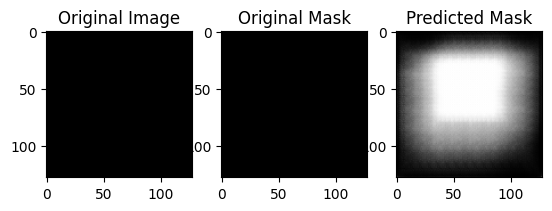

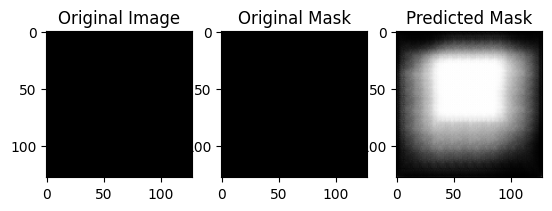

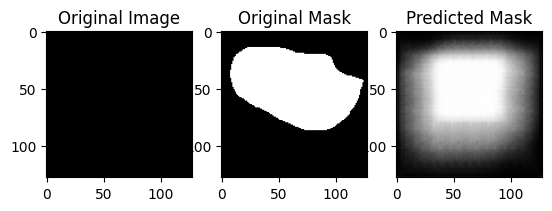

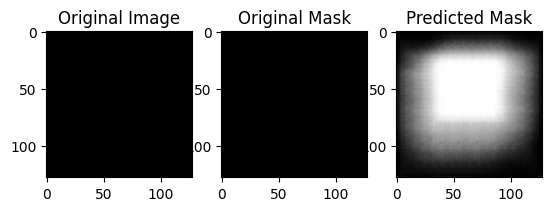

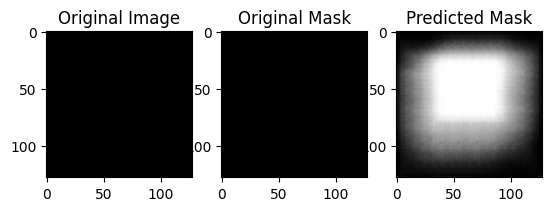

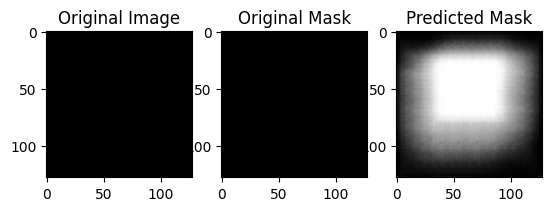

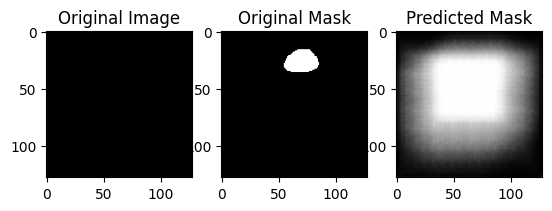

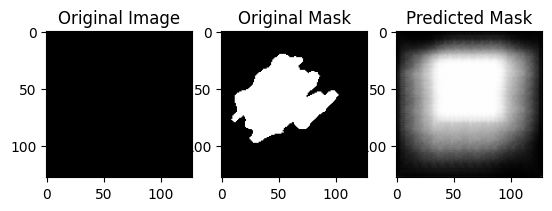

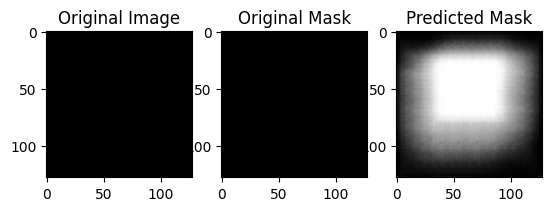

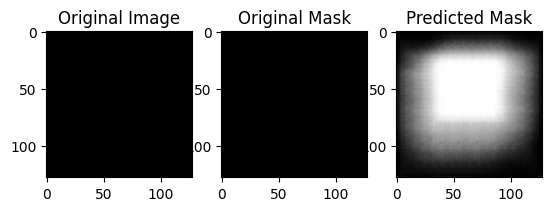

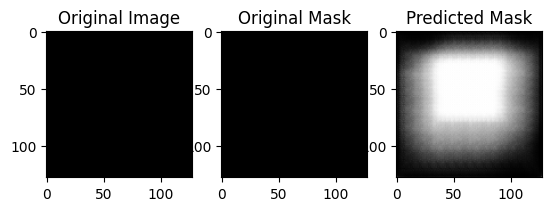

In [52]:
# Storing the segmentation images
predicted_masks = model.predict(X_test)  #predicted masks
#predicted_masks = (predicted_masks > 0.5).astype(np.uint8)
original_images = X_test  # original images
original_masks = y_test #original masks

for i in range(len(predicted_masks)):
    fig, axes = plt.subplots(1, 3)
    axes[0].imshow(original_images[i])
    axes[0].set_title('Original Image')
    axes[1].imshow(original_masks[i].squeeze(), cmap='gray')  # Use cmap='gray' for binary masks
    axes[1].set_title('Original Mask')
    axes[2].imshow(predicted_masks[i].squeeze(), cmap='gray')  # Use cmap='gray' for binary masks
    axes[2].set_title('Predicted Mask')

    # Saving the images
    #plt.savefig(f'image_{i}.png')

##Evaluation

In [53]:
y_true = y_test
y_pred = predicted_masks

def iou_metric(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

# Assuming y_test and y_pred are the ground truth masks and predicted masks respectively
iou_scores = []
for true_mask, pred_mask in zip(y_test, y_pred):
    iou = iou_metric(true_mask, pred_mask)
    iou_scores.append(iou)

average_iou = np.mean(iou_scores)
print(f"Average IoU: {average_iou}")

Average IoU: 0.07006290371857542
